# Métrica de valor comprovado versus valor aprovado

Issue: [#251](https://github.com/lappis-unb/salic-ml/issues/251)

## Objetivos

As INs (Intrução Normativa) podem estabelecer que o valor total comprovado (gasto) em um item não pode exceder em 50% o valor aprovado para aquele item.

Este notebook procura portanto listar todos os itens nesta situaçao de um dado projeto (PRONAC). Além disso, busca também analisar se o número de vezes que esta situação ocorreu no projeto dado é um outlier dentro do segmento do mesmo.

## Introdução

É conhecido que quanto maior o número de itens que ultrapassaram seu valor aprovado em 50%, maior o trabalho que um técnico terá ao realizar a análise financeira deste item. Como o objetivo final é estimar a complexidade de analisar um dado projeto em relação aos demais, a complexidade será construida utilizando o valor absoluto que a situação descrita ocorreu. Ou seja, se um projeto tem 100 itens, e 13 deles ultrapassaram em 50% o valor aprovado, será considerado o valor 13, e não o valor (13/100), ou o valor 13%. 

---
## Preparação

O dataset foi obtido a partir de uma query `.sql`, que está disponível na pasta `/data/scripts/` do projeto.

Nome do arquivo: `planilha_aprovacao_comprovacao.sql`

#### Importando módulos e definindo constantes

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from salicml.utils.read_csv import read_csv

Populating the interactive namespace from numpy and matplotlib


#### Carregando e mostrando dataset a ser utilizado ao longo do estudo

In [2]:
planilha_name = 'planilha_aprovacao_comprovacao.csv'
planilha_comprovacao = read_csv(planilha_name)
display(planilha_comprovacao.dtypes)
display(planilha_comprovacao.head())

IdPRONAC                    int64
PRONAC                      int64
DataProjeto                object
idPlanilhaAprovacao         int64
idPlanilhaItem              int64
Item                       object
idSegmento                 object
vlComprovacao             float64
vlAprovado                float64
idComprovantePagamento      int64
nrCNPJCPF                   int64
nmFornecedor               object
UF                          int64
cdProduto                   int64
cdCidade                    int64
cdEtapa                     int64
proponenteCgcCpf            int64
dtype: object

,IdPRONAC,PRONAC,DataProjeto,idPlanilhaAprovacao,idPlanilhaItem,Item,idSegmento,vlComprovacao,vlAprovado,idComprovantePagamento,nrCNPJCPF,nmFornecedor,UF,cdProduto,cdCidade,cdEtapa,proponenteCgcCpf
0,206555,163776,2016-10-06 18:14:06.297,1994185,3742,Manutenção do Sistema de Ar Condicionado,4B,2200.00,54000.0,363094,3488724000114,SUPRE-AR ARCONDICIONADO LTDA - ME,35,0,355030,4,51582658000190
1,206555,163776,2016-10-06 18:14:06.297,1994185,3742,Manutenção do Sistema de Ar Condicionado,4B,2200.00,54000.0,363111,3488724000114,SUPRE-AR ARCONDICIONADO LTDA - ME,35,0,355030,4,51582658000190
2,206555,163776,2016-10-06 18:14:06.297,1994185,3742,Manutenção do Sistema de Ar Condicionado,4B,18.44,54000.0,362427,58543315000165,METALCLEAN PRODUTOS QUIMICOS LTDA - EPP,35,0,355030,4,51582658000190
3,206555,163776,2016-10-06 18:14:06.297,1994185,3742,Manutenção do Sistema de Ar Condicionado,4B,2900.00,54000.0,363074,3488724000114,SUPRE-AR ARCONDICIONADO LTDA - ME,35,0,355030,4,51582658000190
4,206555,163776,2016-10-06 18:14:06.297,1994185,3742,Manutenção do Sistema de Ar Condicionado,4B,2200.00,54000.0,363097,3488724000114,SUPRE-AR ARCONDICIONADO LTDA - ME,35,0,355030,4,51582658000190


### Extraindo apenas colunas necessárias do dataset

In [3]:
FEATURE_COLUMNS = ['IdPRONAC', 'PRONAC', 'idPlanilhaAprovacao', 'Item', 'idSegmento', 'vlAprovado', 'vlComprovacao']
planilha_comprovacao = planilha_comprovacao[FEATURE_COLUMNS]
display(planilha_comprovacao.dtypes)
display(planilha_comprovacao.head())

IdPRONAC                 int64
PRONAC                   int64
idPlanilhaAprovacao      int64
Item                    object
idSegmento              object
vlAprovado             float64
vlComprovacao          float64
dtype: object

,IdPRONAC,PRONAC,idPlanilhaAprovacao,Item,idSegmento,vlAprovado,vlComprovacao
0,206555,163776,1994185,Manutenção do Sistema de Ar Condicionado,4B,54000.0,2200.00
1,206555,163776,1994185,Manutenção do Sistema de Ar Condicionado,4B,54000.0,2200.00
2,206555,163776,1994185,Manutenção do Sistema de Ar Condicionado,4B,54000.0,18.44
3,206555,163776,1994185,Manutenção do Sistema de Ar Condicionado,4B,54000.0,2900.00
4,206555,163776,1994185,Manutenção do Sistema de Ar Condicionado,4B,54000.0,2200.00


# Extraindo features do dataset

**Features**:

- PRONAC
- Segmento
- Itens: apenas itens que o valor comprovado ultrapassou em 50% o valor aprovado

In [4]:
COMPROVADO = 'vlComprovacao'
APROVADO = 'vlAprovado'

verified_bigger_approved = planilha_comprovacao[COMPROVADO] > (planilha_comprovacao[APROVADO] * 1.5)
df_verified_bigger = planilha_comprovacao[verified_bigger_approved]
display(df_verified_bigger.shape)
display(df_verified_bigger.head())

(139, 7)

,IdPRONAC,PRONAC,idPlanilhaAprovacao,Item,idSegmento,vlAprovado,vlComprovacao
4334,206466,163688,2070953,Contador,12,1000.0,1893.74
8702,173043,140416,1133539,Contador,6C,2000.0,3210.12
13306,183854,148907,2065086,Impressão,6E,23085.0,36630.00
16109,206902,164102,2184248,Telefone,11,110.0,585.74
22987,200798,1510549,1756672,"Seguro (pessoas, obras e equipamentos - especi...",26,503.8,1512.21


## Poucos dados

Em toda a base de dados, há apenas 139 itens orçamentários tal que o valor comprovado ultrapassou em 50% o valor aprovado. 

## Treino

### Divisão de 80% para treino e 20% para teste

In [5]:
from sklearn.model_selection import train_test_split

TEST_SIZE = .2

all_pronacs = planilha_comprovacao.PRONAC.unique()
pronacs_train, pronacs_test = train_test_split(all_pronacs, test_size=TEST_SIZE)

df_train = planilha_comprovacao[planilha_comprovacao['PRONAC'].isin(pronacs_train)]
df_test = planilha_comprovacao[planilha_comprovacao['PRONAC'].isin(pronacs_test)]

print('df_train.size = {}'.format(df_train.shape[0]))
print('df_test.size = {}'.format(df_test.shape[0]))

df_train.size = 172335
df_test.size = 45522


In [6]:
df_segment_group = df_train.groupby('idSegmento')
segment_train = {}
THRESHOLD = 1.5

segment_count = {}

for segment, df_group in df_segment_group:
    pronacs_count_bigger = np.zeros(df_group.PRONAC.unique().size)
    segment_train[segment] = {}
    for i, pronac_df_pronac in enumerate(df_group.groupby('PRONAC')):
        pronac, df_pronac = pronac_df_pronac
        bigger_than_approved = df_pronac[COMPROVADO] > (df_pronac[APROVADO] * THRESHOLD)
        count = np.sum(bigger_than_approved)
        pronacs_count_bigger[i] = count
        
    segment_count[segment] = pronacs_count_bigger
    segment_train[segment]['mean'] = np.mean(pronacs_count_bigger)
    segment_train[segment]['std'] = np.std(pronacs_count_bigger)

### Plotando distribuição do número de comprovações maiores em 50% do que as aprovações

Para este plot, foram considerados os segmentos mais populares: `['11', '33', '32', '12', '4B']`.

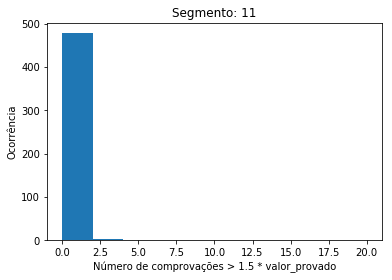

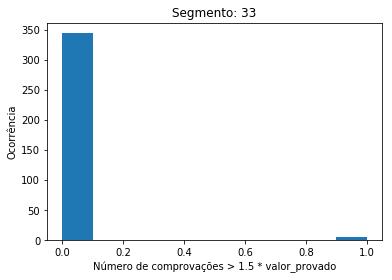

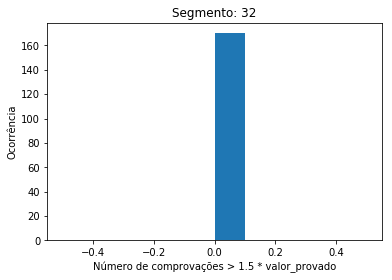

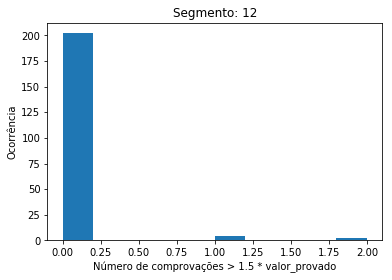

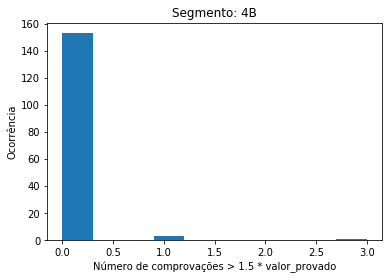

In [7]:
popular_segments = df_train.groupby('idSegmento').count().sort_values('PRONAC', ascending=False).index[:5]
popular_segments

for segment in popular_segments:
    count = segment_count[segment]
    plt.hist(count)
    plt.xlabel('Número de comprovações > 1.5 * valor_provado')
    plt.ylabel('Ocorrência')
    plt.title('Segmento: {}'.format(segment))
    plt.show()

### Histograma das médias de valores comprovados maiores em 50% que o aprovado

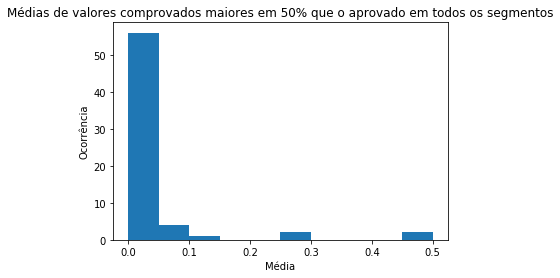

In [8]:
all_means = [value['mean'] for value in segment_train.values()]
plt.hist(all_means)
plt.title('Médias de valores comprovados maiores em 50% que o aprovado em todos os segmentos')
plt.xlabel('Média')
plt.ylabel('Ocorrência')
plt.show()

### Histograma dos desvios padrões de valores comprovados maiores em 50% que o aprovado

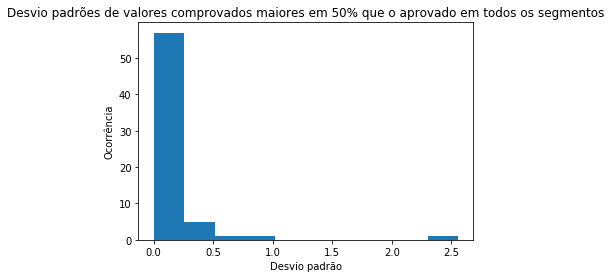

In [9]:
all_std = [value['std'] for value in segment_train.values()]
plt.hist(all_std)
plt.title('Desvio padrões de valores comprovados maiores em 50% que o aprovado em todos os segmentos')
plt.xlabel('Desvio padrão')
plt.ylabel('Ocorrência')
plt.show()

# Teste

In [10]:
from salicml.outliers import gaussian_outlier


df_test_pronac_group = df_test.groupby('PRONAC')

def is_pronac_outlier(pronac):
    response = {
        'is_outlier': False
    }
    
    items = df_test_pronac_group.get_group(pronac)
    segment = items.iloc[0]['idSegmento']
    if segment not in segment_train:
        return response
    
    bigger_than_approved = items[COMPROVADO] > (items[APROVADO] * THRESHOLD)
    mean_std = segment_train[segment]
    
    count = np.sum(bigger_than_approved)
    is_outlier = gaussian_outlier.is_outlier(count, mean_std['mean'], mean_std['std'])
    response['is_outlier'] = is_outlier
    outlier_items = items[bigger_than_approved].Item
    response['outlier_items'] = outlier_items
    return response

for pronac in df_test.PRONAC.unique():
    response = is_pronac_outlier(pronac)
    is_outlier = response['is_outlier']
    if is_outlier:
        print('is_pronac({}) outlier?\n{}'.format(pronac, is_pronac_outlier(pronac)))
        break

is_pronac(1510610) outlier?
{'is_outlier': True, 'outlier_items': 168568    Assistente de produção
Name: Item, dtype: object}


In [11]:
pronacs = df_test.PRONAC.unique()
outlier_count = np.zeros(pronacs.size)

for i, pronac in enumerate(pronacs):
    response = is_pronac_outlier(pronac)
    is_outlier = response['is_outlier']
    outlier_count[i] = is_outlier

pd.DataFrame(outlier_count).describe()

,0
count,536.000000
mean,0.026119
std,0.159639
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


---
## Resultados e Conclusões


Com a divisão de 80/20 para treino e teste, respectivamente, `2.6%` dos PRONACs foram classificados como outliers, enquanto se esperava que aproxidamente `6.7%` dos dados fossem classificados como outliers. O método utilizado para a detecção de outliers foi a `cdf` da Gaussiana, onde valores maiores que `média + 1.5 * desvio_padrão` foram classificados como outliers.

Existem dois possíveis motivos para este resultado:

- A distribuição não é Gaussiana: os plots dos segmentos mais populares demonstram esta propriedade

- Poucos dados: de todo o banco de dados, existiam apenas 139 itens com valores comprovados maiores em 50% que os valores aprovados

Apesar da análise de outliers ter um resultado inconclusivo para a quantidade de dados disponíveis e método escolhido, ainda existe valor na funcionalidade de listar todos os itens que os valores comprovados ultrapassam em 50% os valores aprovados.